**Import The Libraries**

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.linear_model import LinearRegression

**Read Data in Pandas Dataframe**

In [2]:
#db_path = './data/fishing.db'
#conn = sqlite3.connect(db_path)
#data = pd.read_sql_query(sql="SELECT * FROM fishing", con=conn)
#data.head()

data = pd.read_csv('fishing.csv')
data = pd.DataFrame(data)
data.head()

,Date,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,RainToday,RainTomorrow,ColourOfBoats,AverageTemp
0,8/3/2009,Changi,0.0,7.0,11.2,E,35.0,E,ESE,15.0,...,60.0,54.0,MED,Med,4.0,5.0,No,No,blue,33.4
1,12/11/2014,Woodlands,0.0,8.4,9.6,WNW,37.0,NNE,NW,13.0,...,60.0,56.0,MeD,LOw,1.0,2.0,NaN,Yes,blue,35.4
2,8/8/2008,Woodlands,0.0,7.6,11.1,ESE,52.0,SE,E,19.0,...,NaN,13.0,Med,MEd,0.0,0.0,NaN,No,blue,32.8
3,12/10/2015,Changi,0.0,7.2,11.4,NE,31.0,NNW,NE,9.0,...,51.0,53.0,hIgh,med,1.0,1.0,No,No,red,31.4
4,27/10/2013,Woodlands,5.6,7.0,8.5,NNW,33.0,N,N,13.0,...,68.0,64.0,meD,MeD,6.0,5.0,NaN,No,grey,35.4


In [3]:
data.shape

(12997, 21)

**A) DATA CLEANING**

**A.1) Duplicate Rows**

In [4]:
# Check for duplicate rows
duplicate_rows = data[data.duplicated()]

# Print the result
print("Duplicate Rows (excluding first occurrence):")
print(duplicate_rows)

Duplicate Rows (excluding first occurrence):
             Date   Location  Rainfall  Evaporation  Sunshine WindGustDir  \
244    21/12/2010  Woodlands       2.8          5.6       2.1         WSW   
791      6/7/2008       Tuas       6.8          2.4       9.3         NNE   
796     17/2/2011     Changi       2.2          3.6       7.0           E   
1088    25/5/2015       Tuas       0.0          1.0       8.5          SW   
1173     7/8/2012       Tuas       9.6          2.0       7.8          SW   
...           ...        ...       ...          ...       ...         ...   
12973   26/5/2010     Changi       0.0          1.8       9.3           W   
12974   20/9/2015     Changi       0.0          5.6       9.0         SSE   
12983   26/3/2015  Woodlands       1.6          5.4       7.3         NNE   
12985    7/6/2017     Changi       0.0          5.6      10.0          SW   
12994   14/5/2011    Sentosa       8.0          0.8       5.4           S   

       WindGustSpeed WindDir9a

In [5]:
# Remove duplicate rows
data = data.drop_duplicates()

# Display the data without duplicates
print(data)

             Date   Location  Rainfall  Evaporation  Sunshine WindGustDir  \
0        8/3/2009     Changi       0.0          7.0      11.2           E   
1      12/11/2014  Woodlands       0.0          8.4       9.6         WNW   
2        8/8/2008  Woodlands       0.0          7.6      11.1         ESE   
3      12/10/2015     Changi       0.0          7.2      11.4          NE   
4      27/10/2013  Woodlands       5.6          7.0       8.5         NNW   
...           ...        ...       ...          ...       ...         ...   
12991   21/8/2011     Changi       3.0          4.4       1.9          SE   
12992   12/6/2015       Tuas       0.4          1.6       5.6          SW   
12993   29/9/2016     Changi       0.0          7.4       0.6         NNW   
12995   14/2/2011    Sentosa       4.4          4.4      12.0           S   
12996    4/3/2016     Changi       0.4          8.4      11.1           E   

       WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Humidity9am 

In [6]:
data.shape

(11815, 21)

In [7]:
data.dtypes

Date              object
Location          object
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am       object
Pressure3pm       object
Cloud9am         float64
Cloud3pm         float64
RainToday         object
RainTomorrow      object
ColourOfBoats     object
AverageTemp      float64
dtype: object

**Identifying numerical, discrete and continuous features**

In [8]:
# identify numerical features
num_feats = data.select_dtypes(include=['float64']).columns.tolist()

# identify discrete features
discrete_feats = []
for feat in num_feats:
    if data[feat].nunique() < 10:
        discrete_feats.append(feat)

# identify continuous features
continuous_feats = list(set(num_feats) - set(discrete_feats))

print("Numerical Features:", num_feats)
print("Discrete Features:", discrete_feats)
print("Continuous Features:", continuous_feats)

Numerical Features: ['Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Cloud9am', 'Cloud3pm', 'AverageTemp']
Discrete Features: ['Cloud9am', 'Cloud3pm']
Continuous Features: ['WindGustSpeed', 'Sunshine', 'Evaporation', 'Rainfall', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'AverageTemp', 'WindSpeed9am']


**A.2) Invalid Data**

**Check for invalid data for categorical and discrete column**

In [9]:
# To display the labels in each categorical and discrete columns
column_names = [
    'WindGustDir', 'WindDir9am', 'WindDir3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm'
]
    
for column in column_names:
    categories = set(data[column].dropna())
    print(f"Categories for {column}:")
    for category in categories:
        print(f" - {category}")
    print()


Categories for WindGustDir:
 - E
 - WSW
 - NNW
 - S
 - NW
 - NNE
 - SE
 - SSE
 - NE
 - EW
 - N
 - SW
 - NS
 - W
 - ESE
 - WNW
 - SSW
 - ENE

Categories for WindDir9am:
 - E
 - WSW
 - NNW
 - NNE
 - S
 - NW
 - SE
 - SSE
 - NE
 - N
 - SW
 - W
 - ESE
 - WNW
 - SSW
 - ENE

Categories for WindDir3pm:
 - E
 - WSW
 - NNW
 - NW
 - NNE
 - S
 - SE
 - SSE
 - NE
 - N
 - SW
 - W
 - ESE
 - WNW
 - SSW
 - ENE

Categories for Pressure9am:
 - med
 - lOW
 - HIgH
 - low
 - LOw
 - High
 - HiGh
 - hiGh
 - higH
 - MEd
 - meD
 - LOW
 - high
 - lOw
 - HigH
 - hIGH
 - mEd
 - HiGH
 - hIgh
 - hIgH
 - hIGh
 - LoW
 - HIGH
 - MeD
 - HIgh
 - HIGh
 - mED
 - loW
 - Med
 - MED
 - Low
 - hiGH

Categories for Pressure3pm:
 - med
 - lOW
 - HIgH
 - low
 - LOw
 - High
 - HiGh
 - hiGh
 - higH
 - MEd
 - meD
 - LOW
 - high
 - lOw
 - HigH
 - hIGH
 - HiGH
 - mEd
 - hIgH
 - LoW
 - hIgh
 - hIGh
 - HIGH
 - MeD
 - HIgh
 - HIGh
 - mED
 - loW
 - Med
 - MED
 - Low
 - hiGH

Categories for Cloud9am:
 - 0.0
 - 1.0
 - 2.0
 - 3.0
 - 4.0
 - 5.

**Change Pressure Data columns To Uppercase for consistency**

In [10]:
data['Pressure9am'] = data['Pressure9am'].str.upper()
data['Pressure3pm'] = data['Pressure3pm'].str.upper()


There are negative values for the sunshine hours, indicating erroneous data.

To address this issue, we will convert the sunshine values to their absolute values. This will ensure that all the values in the 'Sunshine' column are positive, rectifying the erroneous data.

In [11]:
# Convert the negative value in the Sunshine column to positive
data['Sunshine'] = data['Sunshine'].abs()

**A.3) Missing Data**

In [12]:
# Count missing data for each column
missing_data_count = data.isnull().sum()

# Print the count of missing data for each column
print(missing_data_count)

Date                0
Location            0
Rainfall            0
Evaporation        74
Sunshine           57
WindGustDir        75
WindGustSpeed      72
WindDir9am        265
WindDir3pm         47
WindSpeed9am        4
WindSpeed3pm        5
Humidity9am        14
Humidity3pm        25
Pressure9am         2
Pressure3pm         7
Cloud9am          277
Cloud3pm          342
RainToday        2903
RainTomorrow        0
ColourOfBoats       0
AverageTemp         8
dtype: int64


The total count of missing data above is 3,311, which is approximately 28.01% of the total data count.

Fill the missing data with the mean or median, depending on the distribution curve, or mode if it is discrete data.

RainToday column can be removed since it is a function of the Rainfall column. RainToday Column also makes up the bulk of the missing data. 

**A.4) Determine number of outliers**



In [13]:
# List of numeric column names
column_names = [
    'WindGustSpeed', 'WindSpeed3pm', 'Sunshine', 'Evaporation', 'Humidity9am','Humidity3pm', 'Rainfall', 'WindSpeed9am', 'AverageTemp', 'Cloud3pm', 'Cloud9am'
]

# Function to count outliers using the IQR method
def count_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return ((series < lower_bound) | (series > upper_bound)).sum()

# Count the number of outliers for each column
outliers_counts = {}
for column in column_names:
    if data[column].dtype in ['int64', 'float64']:  # Check if the column contains numerical data
        # outliers_count = count_outliers(data[column].dropna())  # Count outliers without missing values
        outliers_count = count_outliers(data[column])
        outliers_counts[column] = outliers_count

# Print the number of outliers for each column
for column, count in outliers_counts.items():
    print(f"{column}: {count} outliers")

WindGustSpeed: 383 outliers
WindSpeed3pm: 314 outliers
Sunshine: 0 outliers
Evaporation: 103 outliers
Humidity9am: 127 outliers
Humidity3pm: 139 outliers
Rainfall: 2333 outliers
WindSpeed9am: 333 outliers
AverageTemp: 0 outliers
Cloud3pm: 0 outliers
Cloud9am: 0 outliers


Based on the outlier count above for each of the numerical data columns, the total number of outliers is more than 30% of the dataset.

This is significant; thus, we will not remove the outliers.




**A.5) Summary Statistics**

In [14]:
# Get summary statistics for each numerical column
summary_statistics = data.describe()

# Print summary statistics
print(summary_statistics)


           Rainfall   Evaporation      Sunshine  WindGustSpeed  WindSpeed9am  \
count  11815.000000  11741.000000  11758.000000   11743.000000  11811.000000   
mean       3.086669      5.557457      8.077190      36.664311     12.467361   
std       11.173648      2.901247      3.629437      12.631501      8.325970   
min        0.000000      0.000000      0.000000       9.000000      0.000000   
25%        0.000000      3.400000      5.700000      28.000000      7.000000   
50%        0.000000      5.400000      9.200000      35.000000     11.000000   
75%        0.800000      7.400000     10.800000      43.000000     17.000000   
max      367.600000     44.000000     13.900000     126.000000     65.000000   

       WindSpeed3pm   Humidity9am   Humidity3pm      Cloud9am      Cloud3pm  \
count  11810.000000  11801.000000  11790.000000  11538.000000  11473.000000   
mean      16.700931     65.489196     50.851145      4.122032      4.129434   
std        7.870736     15.451693     16.8

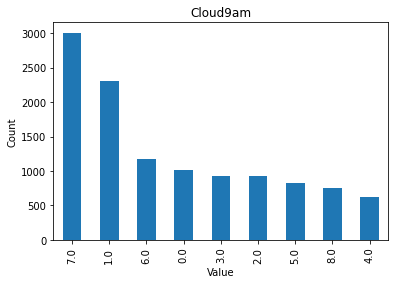

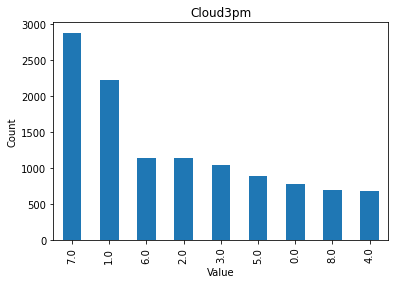

In [15]:
# Create bar plot for each discrete feature
for feat in discrete_feats:
    plt.figure()
    data[feat].value_counts().plot(kind='bar')
    plt.title(feat)
    plt.xlabel('Value')
    plt.ylabel('Count')

plt.show()

As Column [Cloud9am] and [Cloud3pm] is skewed, median would be used to fill the missing values.Median is less sensitive to extreme values and may provide a better central tendency measure for skewed data.

In [16]:
data['Cloud9am'].fillna(data['Cloud9am'].median(), inplace=True)
data['Cloud3pm'].fillna(data['Cloud3pm'].median(), inplace=True)

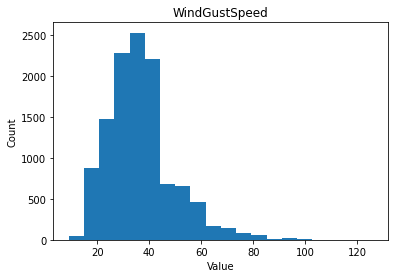

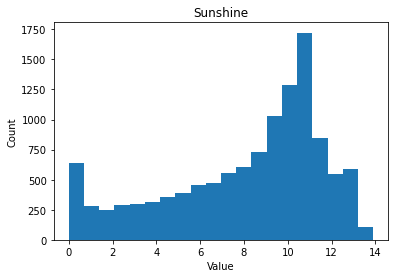

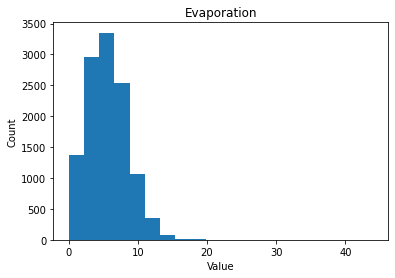

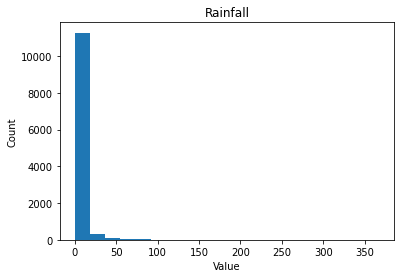

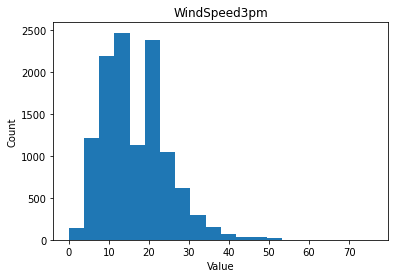

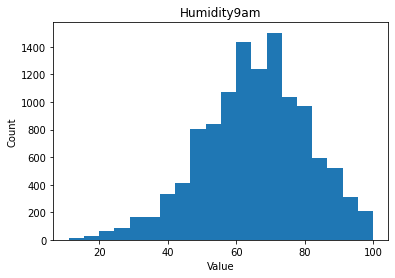

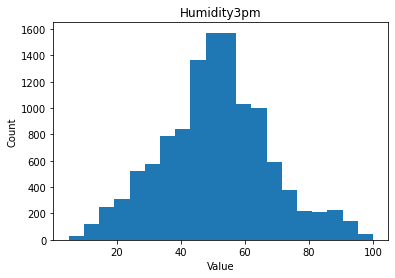

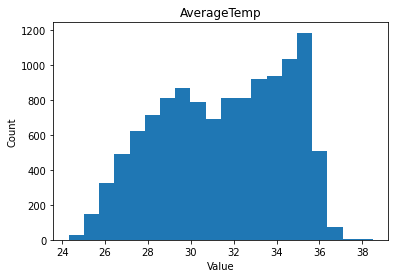

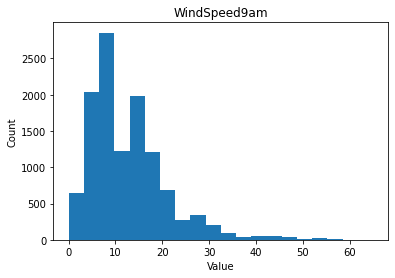

In [17]:
# Create histogram for each continuous feature
for feat in continuous_feats:
    plt.figure()
    plt.hist(data[feat], bins=20)
    plt.title(feat)
    plt.xlabel('Value')
    plt.ylabel('Count')

plt.show()

Fill column [AverageTemp] with mean as it's normal distributed and has no outliers.

In [18]:
# Calculate the mean of AverageTemp and fill missing data with the mean value.
col_mean = int(data['AverageTemp'].mean())
data['AverageTemp'].fillna(col_mean, inplace=True)

Fill columns [WindGustSpeed],[WindSpeed9am], [WindSpeed3pm], [Sunshine], [Evaporation], [Humidity9am],[Humidity3pm], [Rainfall]) missing data with median. Median is used because the distibution shown above is skewed and there are number of outliers.

In [19]:
# List of specified column names containing continuous numerical data with missing values.
column_names = [
  'WindGustSpeed','WindSpeed9am', 'WindSpeed3pm', 'Sunshine', 'Evaporation', 'Humidity9am','Humidity3pm', 'Rainfall']

# Calculate the median and fill missing values for each column
for column in column_names:
    if data[column].dtype in ['int64', 'float64']:  # Check if the column contains numerical data
        col_median = round(data[column].median(), 1)  # Calculate the median and round to one decimal place
        data[column].fillna(col_median, inplace=True)


As column [WindGustDir] , [WindDir9am], [WindDir3pm], [Pressure9am], and [Pressure3pm] are categorical variables. Mode would be used to fill the missing data.

In [20]:
# List of specified column names of categorical data with missing values.
column_names = [
    'WindGustDir', 'WindDir3pm', 'WindDir9am', 'Pressure3pm', 'Pressure9am']

# Calculate the mode and fill missing values for each column
for column in column_names:
    col_mode = data[column].mode()
    data[column].fillna(col_mode, inplace=True)


Column [Sunshine] and [Cloud3pm] has a a correlation of (-0.71) which indicates a relatively strong negative linear relationship between two variables.

WindGustSpeed is positively correlated with WindSpeed9am (0.69) and WindSpeed3pm (0.72).

**A.6) Correlation Analysis**


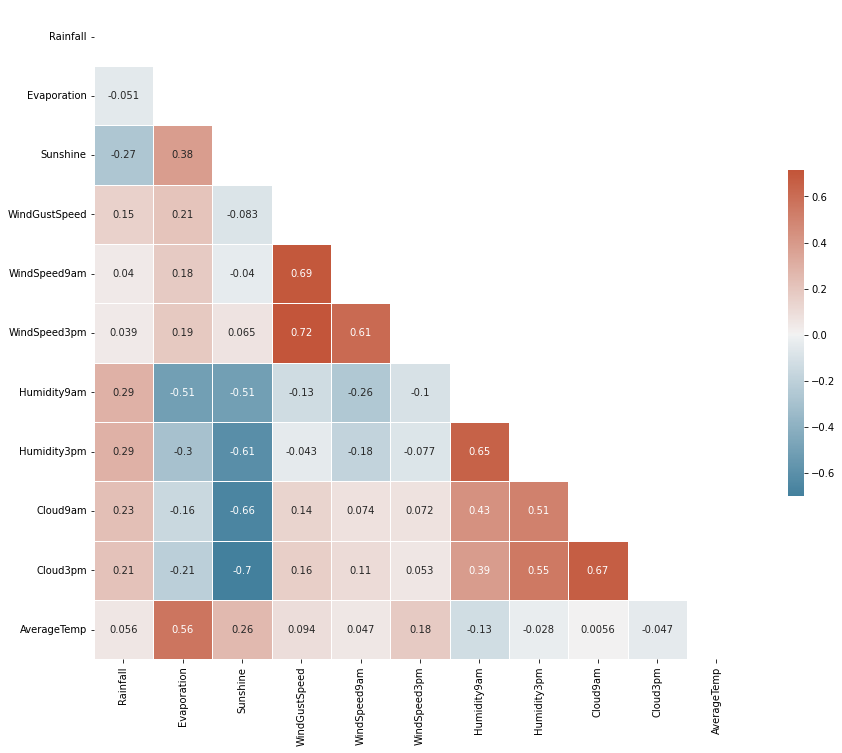

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the correlation matrix for all columns
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()



**A.7) Extract Year, Month, and Day Features from 'Date'**

In [22]:
# Convert 'Date' to datetime format and extract year, month, and day
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y', infer_datetime_format=True)
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

**A.8) Create a new column 'RainTomorrow_MM'**

In [23]:
# Shift the 'Rainfall' column by one day
data['RainTomorrow_MM'] = data['Rainfall'].shift(-1)

# Convert to binary indicating whether there's more than 1.0 mm of rain
data['RainTomorrow_MM'] = (data['RainTomorrow_MM'] > 1.0).astype(int)

# Drop the last row because it will have a missing value in 'RainTomorrow_MM'
data = data.iloc[:-1]

# Save DataFrame to CSV
data.to_csv('data_new_column.csv', index=False)



**A.9) Grouping Similar Cloud Values**


In [24]:
# Binning the "Cloud9am" column
bins = [-1, 2, 5, 7, 8]  # The bins we'll use
labels = ['Clear', 'Partly Cloudy', 'Cloudy', 'Overcast']  # Corresponding labels for the bins
data['Cloud9am_Binned'] = pd.cut(data['Cloud9am'], bins=bins, labels=labels, right=True)

# Binning the "Cloud3pm" column
bins = [-1, 2, 5, 7, 8]  # The bins we'll use
labels = ['Clear', 'Partly Cloudy', 'Cloudy', 'Overcast']  # Corresponding labels for the bins
data['Cloud3pm_Binned'] = pd.cut(data['Cloud3pm'], bins=bins, labels=labels, right=True)


**A.10) Drop Unnecessary Columns in the Dataset**

We can drop the "Date" column since we have already extracted the Year, Month, and Day information.

The "ColourOfBoats" column can be removed as it is irrelevant for predicting rain tomorrow.

The "RainToday" column is redundant as it can be defined by the "Rainfall" column. Rain is considered present when the rainfall is greater than or equal to 1.0 and absent when it is less than 1.0.

Based on the correlation analysis, we will drop the "Sunshine" column as it has a strong negative correlation of -0.71 with the "Cloud3pm" column. Similarly, the "WindGustSpeed" column will be dropped as it has a positive correlation with the "WindSpeed3pm" column.


In [25]:
# Data Selection
X = data.loc[:, ['Location', 'Rainfall', 'Evaporation',
       'WindGustDir', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am_Binned', 'Cloud3pm_Binned',
       'AverageTemp', 'Year', 'Month', 'Day']]
Y = data['RainTomorrow_MM']

In [26]:
print (X) 

        Location  Rainfall  Evaporation WindGustDir WindDir9am WindDir3pm  \
0         Changi       0.0          7.0           E          E        ESE   
1      Woodlands       0.0          8.4         WNW        NNE         NW   
2      Woodlands       0.0          7.6         ESE         SE          E   
3         Changi       0.0          7.2          NE        NNW         NE   
4      Woodlands       5.6          7.0         NNW          N          N   
...          ...       ...          ...         ...        ...        ...   
12990       Tuas       0.0          4.0         NNW        NNE        WNW   
12991     Changi       3.0          4.4          SE        SSW         SE   
12992       Tuas       0.4          1.6          SW        NaN         SW   
12993     Changi       0.0          7.4         NNW          N        NNW   
12995    Sentosa       4.4          4.4           S        SSE        SSE   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm Pressure9am  \


In [27]:
from sklearn.impute import SimpleImputer

# Impute Missing Values
imputer = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
Y = pd.DataFrame(imputer.fit_transform(Y.values.reshape(-1, 1)), columns=['RainTomorrow_MM'])

**B) ONE HOT ENCODING**

In [28]:
# One-hot encode the categorical columns in 'X' excluding 'Pressure' columns
X = pd.get_dummies(X, columns=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm','Cloud9am_Binned','Cloud3pm_Binned'])

In [29]:
from sklearn.preprocessing import OrdinalEncoder

# Create the encoder
encoder = OrdinalEncoder(categories=[['LOW', 'MED', 'HIGH'],['LOW', 'MED', 'HIGH']])   # specify the order of categories

# Apply the encoder to 'Pressure9am' and 'Pressure3pm'
X.loc[:, ['Pressure9am', 'Pressure3pm']] = encoder.fit_transform(X.loc[:, ['Pressure9am', 'Pressure3pm']])


In [30]:
print(X)

      Rainfall Evaporation WindSpeed9am WindSpeed3pm Humidity9am Humidity3pm  \
0          0.0         7.0         15.0         19.0        60.0        54.0   
1          0.0         8.4         13.0         28.0        60.0        56.0   
2          0.0         7.6         19.0         19.0        66.0        13.0   
3          0.0         7.2          9.0         13.0        51.0        53.0   
4          5.6         7.0         13.0         19.0        68.0        64.0   
...        ...         ...          ...          ...         ...         ...   
11809      0.0         4.0         13.0         17.0        65.0        47.0   
11810      3.0         4.4          6.0         17.0        89.0        51.0   
11811      0.4         1.6          0.0         13.0        92.0        66.0   
11812      0.0         7.4          4.0          9.0        57.0        48.0   
11813      4.4         4.4         13.0          9.0        68.0        52.0   

       Pressure9am  Pressure3pm Average

In [31]:
# Convert to NumPy array and reshape to 2D
Y = Y.to_numpy().reshape(-1, 1)

**C) FEATURE SCALING**





In [32]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [33]:
# !pip install -U imbalanced-learn

**D) Handling Imbalanced Data**

In [34]:
# Count 'yes' and 'no' occurrences for dependent parameter
counts = data['RainTomorrow_MM'].value_counts()
print("RainTomorrow_MM :\n", counts)

RainTomorrow_MM :
 0    9033
1    2781
Name: RainTomorrow_MM, dtype: int64


**D.1) Create synthetic imbalanced dataset**

In [35]:
from sklearn.datasets import make_classification

# Print number of samples
print("Number of samples in X:", X.shape[0])
print("Number of samples in Y:", Y.shape[0])

# Generate a synthetic imbalanced dataset
X, y = make_classification(n_samples=11814, n_features=10, weights=[0.95, 0.05], random_state=42)

Number of samples in X: 11814
Number of samples in Y: 11814


**E) Data Splitting**

In [36]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [37]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [38]:
from imblearn.over_sampling import ADASYN

# Apply ADASYN to oversample the minority class
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Check the class distribution after oversampling
print("Class distribution after ADASYN:")
unique, counts = np.unique(y_train_resampled, return_counts=True)
print(dict(zip(unique, counts)))


Class distribution after ADASYN:
{0: 8932, 1: 8853}


**F) Evaluation Metrics**

**Ensemble classifier**

In [47]:
'''
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

# List of models
models = [
    ("KNN", KNeighborsClassifier()),
    ("RandomForest", RandomForestClassifier()),
    ("SupportVector",SVC()),
    ("GradientBoosting", GradientBoostingClassifier()),
    ("DecisionTree", DecisionTreeClassifier()),
    ("AdaBoost", AdaBoostClassifier()) 
    
]

# Create the ensemble classifier using VotingClassifier
ensemble_classifier = VotingClassifier(
    estimators=models
)

# Train the ensemble classifier
ensemble_classifier.fit(X_train, y_train)

# Make predictions using the ensemble classifier
y_pred_ensemble = ensemble_classifier.predict(X_test)

# Evaluate the performance of the ensemble classifier
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
classification_report_ensemble = classification_report(y_test, y_pred_ensemble)

# Print the evaluation results for the ensemble classifier
print("Ensemble Classifier Evaluation:")
print(f"Accuracy: {accuracy_ensemble:.2f}")
print("Classification Report:")
print(classification_report_ensemble)

# Perform individual model evaluation
for name, classifier in ensemble_classifier.named_estimators_.items():
    y_pred_individual = classifier.predict(X_test)
    accuracy_individual = accuracy_score(y_test, y_pred_individual)
    classification_report_individual = classification_report(y_test, y_pred_individual)
    
    # Print the evaluation results for each individual model
    print(f"\nIndividual Model: {name}")
    print(f"Accuracy: {accuracy_individual:.2f}")
    print("Classification Report:")
    print(classification_report_individual)
'''


'\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.svm import SVC\nfrom sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.tree import DecisionTreeClassifier\nfrom sklearn.ensemble import AdaBoostClassifier\nfrom sklearn.ensemble import VotingClassifier\n\n# List of models\nmodels = [\n    ("KNN", KNeighborsClassifier()),\n    ("RandomForest", RandomForestClassifier()),\n    ("SupportVector",SVC()),\n    ("GradientBoosting", GradientBoostingClassifier()),\n    ("DecisionTree", DecisionTreeClassifier()),\n    ("AdaBoost", AdaBoostClassifier()) \n    \n]\n\n# Create the ensemble classifier using VotingClassifier\nensemble_classifier = VotingClassifier(\n    estimators=models\n)\n\n# Train the ensemble classifier\nensemble_classifier.fit(X_train, y_train)\n\n# Make predictions using the ensemble classifier\ny_pred_ensemble = ensemble_classifier.predict(X_test)\n\n# Evaluate the performance of the ensemble 

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier

# Dictionary for classifiers (models)
model_objs = {
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier(),
    'SupportVector': SVC(),
    'GradientBoosting': GradientBoostingClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'AdaBoost': AdaBoostClassifier()
}


# Define hyperparameters for each classifier
param_distributions = {
    'KNN': {
        'n_neighbors': np.arange(1, 31),
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # L1 and L2 distance
    },
    'RandomForest': {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': np.arange(2, 11),
        'min_samples_leaf': np.arange(1, 11)
    },
    'SupportVector': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto']
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 150, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
        'max_depth': [3, 5, 7, 9]
    },
    'DecisionTree': {
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': np.arange(2, 11),
        'min_samples_leaf': np.arange(1, 11)
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 150, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]
    }
}

    
    
# Find best params for each model and train them with it
trained_models = []
for name, classifier in model_objs.items():
    randomized_search = RandomizedSearchCV(classifier, param_distributions=param_distributions[name], 
                                           n_iter=50, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
    randomized_search.fit(X_train, y_train)
    
    # Update the classifier with best params and train it
    classifier.set_params(**randomized_search.best_params_)
    classifier.fit(X_train, y_train)
    
    trained_models.append((name, classifier))
    
    print(f"Best Parameters for {name}: {randomized_search.best_params_}")


# Create the ensemble classifier using VotingClassifier
ensemble_classifier = VotingClassifier(
    estimators=trained_models
)

# Train the ensemble classifier
ensemble_classifier.fit(X_train, y_train)

# Make predictions using the ensemble classifier
y_pred_ensemble = ensemble_classifier.predict(X_test)

# Evaluate the performance of the ensemble classifier
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
classification_report_ensemble = classification_report(y_test, y_pred_ensemble)

# Print the evaluation results for the ensemble classifier
print("Ensemble Classifier Evaluation:")
print(f"Accuracy: {accuracy_ensemble:.2f}")
print("Classification Report:")
print(classification_report_ensemble)

# Perform individual model evaluation
for name, classifier in ensemble_classifier.named_estimators_.items():
    y_pred_individual = classifier.predict(X_test)
    accuracy_individual = accuracy_score(y_test, y_pred_individual)
    classification_report_individual = classification_report(y_test, y_pred_individual)
    
    # Print the evaluation results for each individual model
    print(f"\nIndividual Model: {name}")
    print(f"Accuracy: {accuracy_individual:.2f}")
    print("Classification Report:")
    print(classification_report_individual)





Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for KNN: {'weights': 'distance', 'p': 1, 'n_neighbors': 6}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for RandomForest: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\thedi\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for SupportVector: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for GradientBoosting: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.5}
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for DecisionTree: {'min_samples_split': 6, 'min_samples_leaf': 6, 'max_depth': 10}
Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\thedi\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters for AdaBoost: {'n_estimators': 200, 'learning_rate': 0.5}
Ensemble Classifier Evaluation:
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2219
           1       1.00      0.82      0.90       144

    accuracy                           0.99      2363
   macro avg       0.99      0.91      0.95      2363
weighted avg       0.99      0.99      0.99      2363


Individual Model: KNN
Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2219
           1       1.00      0.73      0.84       144

    accuracy                           0.98      2363
   macro avg       0.99      0.86      0.92      2363
weighted avg       0.98      0.98      0.98      2363


Individual Model: RandomForest
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0    

**Cross Validation**

In [49]:
from sklearn.model_selection import cross_val_score

# List of models 
models = [
    ("KNN", KNeighborsClassifier()),
    ("RandomForest", RandomForestClassifier()),
    ("SupportVector",SVC()),
    ("GradientBoosting", GradientBoostingClassifier()),
    ("DecisionTree", DecisionTreeClassifier()),
    ("AdaBoost", AdaBoostClassifier()) 
    
]

# Loop through each model, train using cross-validation, and print results
for name, model in models:
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=10)
    print(f"{name} - Cross-validation scores: {scores}")
    print(f"{name} - Average cross-validation score: {scores.mean()}\n")

KNN - Cross-validation scores: [0.93029792 0.91455874 0.93029792 0.96121417 0.92692524 0.93025872
 0.91901012 0.94375703 0.95725534 0.94094488]
KNN - Average cross-validation score: 0.9354520082122955

RandomForest - Cross-validation scores: [0.94266442 0.92467678 0.90612704 0.9668353  0.9584036  0.94488189
 0.92463442 0.95950506 0.96512936 0.94713161]
RandomForest - Average cross-validation score: 0.9439989478549583

SupportVector - Cross-validation scores: [0.871276   0.88982574 0.82630691 0.90893761 0.91062395 0.90044994
 0.86782902 0.9071991  0.92463442 0.89988751]
SupportVector - Average cross-validation score: 0.8906970207982011

GradientBoosting - Cross-validation scores: [0.88026981 0.89938168 0.81618887 0.88308038 0.91568297 0.86445444
 0.84983127 0.90944882 0.86164229 0.88863892]
GradientBoosting - Average cross-validation score: 0.8768619457980906

DecisionTree - Cross-validation scores: [0.89994379 0.90949972 0.89432265 0.9336706  0.94097808 0.91957255
 0.90438695 0.9415073

**Area under the curve score**

In [50]:
from sklearn.metrics import roc_auc_score

# List of models
models = [
    ("KNN", KNeighborsClassifier()),
    ("RandomForest", RandomForestClassifier()),
    ("SupportVector", SVC(probability=True)),
    ("GradientBoosting", GradientBoostingClassifier()),
    ("DecisionTree", DecisionTreeClassifier()),
    ("AdaBoost", AdaBoostClassifier()) 
    
]


# Loop through each model,Instantiate and fit the model. 
for name, model in models:
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict the probabilities of the test data
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Calculate AUROC
    auroc = roc_auc_score(y_test, y_pred_prob)
    
    print(f"{name} - Auroc: {auroc}")
 


KNN - Auroc: 0.9119082043963748
RandomForest - Auroc: 0.9209134495017777
SupportVector - Auroc: 0.9128987031195233
GradientBoosting - Auroc: 0.9111618096239548
DecisionTree - Auroc: 0.8995011516699215
AdaBoost - Auroc: 0.9134917505382805


**Confusion matrix chart**

Ensemble Classifier Confusion matrix, without normalization
[[2219    0]
 [  26  118]]
Ensemble Classifier Normalized confusion matrix
[[1.         0.        ]
 [0.18055556 0.81944444]]


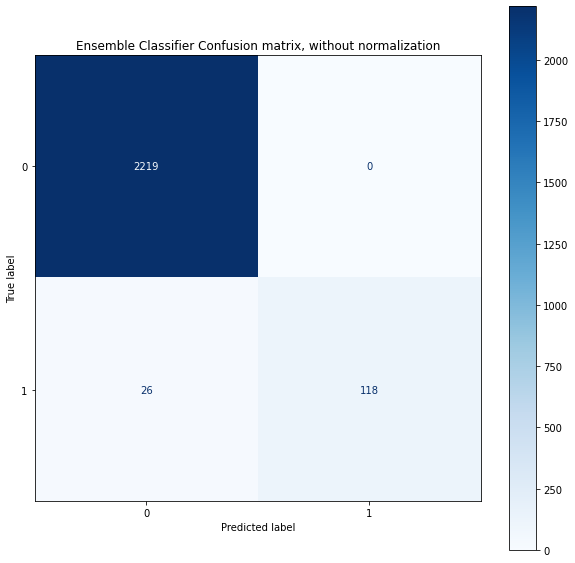

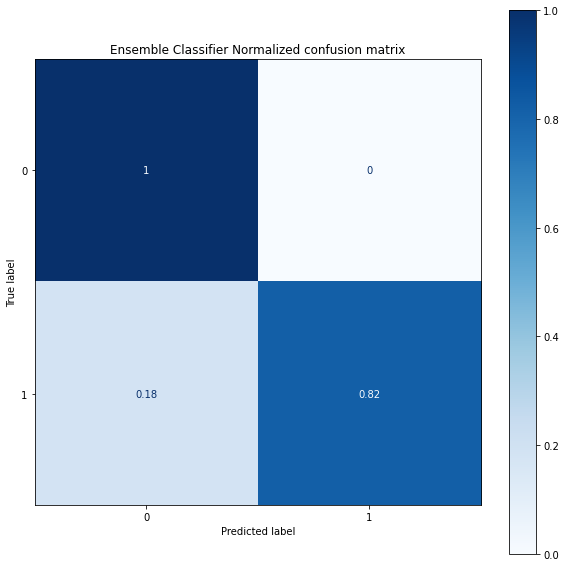

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = np.unique(y_test)

titles_options = [
    ("Ensemble Classifier Confusion matrix, without normalization", None),
    ("Ensemble Classifier Normalized confusion matrix", "true"),
]

# Predict using  classifier
y_pred = ensemble_classifier.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(10, 10))
    
    if normalize == "true":
        cm_display = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        cm_display = cm
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_display, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    
    ax.set_title(title)
    ax.grid(False)

    print(title)
    print(cm_display)

